# Forage de données - TP1

In [64]:
import pandas as pd


# Loading data from 'QSAR_dataset.xlsx' file
data = pd.read_excel('QSAR_dataset.xlsx')

## 1. Réprésentation des données

### 1.(a) Analyse des données

#### Analyse de chaque attribut

Pour analyser chaque attribut, on affiche différentes informations pertinentes qui permettront de prendre des décisions sur le prétraitement des données.

Il est possible d'écrire ces informations dans un fichier texte au lieu de les afficher directement dans le notebook en utilisant l'option `file`.

In [38]:
def data_overview(data, file=False):
    """
    Print an overview of each column in the dataset including 
    information about the values, their data type, the distribution and the number of missing values.
    :param data: pandas DataFrame
    :param file: bool, if True, write the output to a file
    """
    for col in data.columns:
        d = data[col]
        overview_str = f'{" " + col + " ":*^20}\n'
        overview_str += f'Data type: {"Float" if d.dtype == "float64" else "Integer" if d.dtype == "int64" else "String"}\n\n'

        overview_str += '- About the values:\n'
        overview_str += f'{"Number of missing values:":>25} {d.isnull().sum()}\n'
        overview_str += f'{"Number of unique values:":>25} {d.nunique()}\n'
        mode = d.mode()
        overview_str += f'{"Mode:":>25} {mode[0]}\n'
        try:
            overview_str += f'{"Mean:":>25} {d.mean():.2f}\n'
            overview_str += f'{"Median:":>25} {d.median()}\n'
            overview_str += f'{"Min:":>25} {d.min()}\n'
            overview_str += f'{"Max:":>25} {d.max()}\n\n'

            overview_str += '- About the distribution:\n'
            overview_str += f'{"Variance:":>25} {d.var():.2f}\n'
            overview_str += f'{"Standard deviation:":>25} {d.std():.2f}\n'
            quantiles = d.quantile([0.25, 0.75])
            overview_str += f'{"First quartile:":>25} {quantiles[0.25]:.2f}\n'
            overview_str += f'{"Third quartile:":>25} {quantiles[0.75]:.2f}\n'
            interquartile_range = quantiles[0.75] - quantiles[0.25]
            overview_str += f'{"Interquartile range:":>25} {interquartile_range:.2f}\n'
            factor = 1.5
            outliers = d[(d < quantiles[0.25] - factor * interquartile_range) | (d > quantiles[0.75] + factor * interquartile_range)]
            overview_str += f'{"Number of outliers:":>25} {outliers.count()}\n'
            if outliers.count() > 0:
                print(f'hey {outliers.count()}')
        except TypeError:
            pass
        overview_str += '\n\n'
        if file:
            with open('data_overview.txt', 'a') as f:
                f.write(overview_str)
        else:
            print(overview_str)

data_overview(data, file=False)

****** SMILES ******
Data type: String

- About the values:
Number of missing values: 0
 Number of unique values: 103
                    Mode: Clc1c(Cl)c(-c2c(Cl)cc(Cl)c(Cl)c2)cc(Cl)c1[O-]



****** Class *******
Data type: String

- About the values:
Number of missing values: 0
 Number of unique values: 5
                    Mode: Class -1



hey 5
******* apol *******
Data type: Float

- About the values:
Number of missing values: 0
 Number of unique values: 74
                    Mode: 35.353966
                    Mean: 34.61
                  Median: 35.579689
                     Min: 17.148172
                     Max: 52.422001

- About the distribution:
                Variance: 35.42
      Standard deviation: 5.95
          First quartile: 31.53
          Third quartile: 38.40
     Interquartile range: 6.87
      Number of outliers: 5



hey 3
******* ASA+ *******
Data type: Float

- About the values:
Number of missing values: 2
 Number of unique values: 103
                

#### Prétraitement des données

Forts de ces informations, nous pouvons maintenant effectuer le prétraitement des données. Pour chaque attribut, nous allons prendre des décisions sur les actions à entreprendre pour nettoyer les données. Nous ne tiendrons pas compte du nombre de valeurs aberrantes, elles sont calculées avec l'écart interquartile et ne tiennent pas compte de l'écart type donc sont largement surestimées.

En voici un résumé :
- l'attribut 'SMILES' étant une chaîne de caractères représentant une molécule, nous allons le supprimer.
- l'attribut 'Class' étant une chaîne de caractères représentant la classe de la molécule entre -2 et 2, nous allons le convertir en entier.
- les classes 2 et -2 étant très peu représentées, nous allons les supprimer.
- nous allons remplacer les valeurs manquantes par la moyenne des valeurs non manquantes. Les classes 'vsurf_S' et 'vsurf_V' sont les seules qui contiennent un nombre significatif de valeurs manquantes. 
- nous allons centrer-réduire les valeurs des attributs numériques (tous sauf 'Class').

In [65]:
def data_preprocessing(data):
    """
    Preprocess the data by removing the 'SMILES' column, converting the 'Class' column to integers, removing the rows with 'Class' values of 2 and -2, replacing missing values in 'vsurf_S' and 'vsurf_V' by the mean of the non-missing values, and standardizing the numerical columns.
    :param data: pandas DataFrame
    :return: pandas DataFrame
    """
    data = data.drop(columns=['SMILES'])
    data = data.replace({'Class': r'Class (.*)'}, r'\1', regex=True)
    data['Class'] = data['Class'].astype(int)
    data = data[(data['Class'] != 2) & (data['Class'] != -2)]
    data.fillna(data.mean(), inplace=True)
    target = data['Class']
    data_without_target = data.drop(columns=['Class'])
    data_without_target = (data_without_target - data_without_target.mean()) / data_without_target.std()
    data = pd.concat([target, data_without_target], axis=1)
    return data

data = data_preprocessing(data)

#### Sélection des 10 meilleurs attributs

Puisqu'il est demandé un justification statistique pour la sélection des 10 meilleurs attributs, nous allons utiliser le test ANOVA pour sélectionner les attributs les plus significatifs.

In [59]:
from sklearn.feature_selection import f_classif


def feature_selection_ANOVA(data_without_class, target, n=10):
    """
    Perform feature selection using ANOVA F-value as a metric.
    :param data_without_class: pandas DataFrame
    :param target: pandas Series
    :param n: int, number of features to select
    :return: list of strings, the names of the selected features
    """
    f_values, p_values = f_classif(data_without_class, target)
    f_values = pd.Series(f_values, index=data_without_class.columns)
    f_values = f_values.sort_values(ascending=False)
    return f_values.index[:n].tolist()

selected_features_ANOVA = feature_selection_ANOVA(data.drop(columns=['Class']), data['Class'])
print(selected_features_ANOVA)

['SlogP', 'h_logP', 'logS', 'h_logS', 'a_nCl', 'SMR', 'mr', 'RPC-', 'apol', 'vsa_hyd']


On peut aussi utiliser une méthode de sélection par modèle, par exemple en utilisant des arbres de décision pour sélectionner les attributs les plus importants avec XGBoost.

In [75]:
import xgboost as xgb


def feature_selection_XGB(data_without_class, target, n=10):
    """
    Perform feature selection using XGBoost feature importance as a metric.
    :param data_without_class: pandas DataFrame
    :param target: pandas Series
    :param n: int, number of features to select
    :return: list of strings, the names of the selected features
    """
    model = xgb.XGBClassifier()
    # Translates target by +1 for XGBoost
    target = target + 1
    model.fit(data_without_class, target)
    feature_importances = model.feature_importances_
    feature_importances = pd.Series(feature_importances, index=data_without_class.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    return feature_importances.index[:n].tolist()

selected_features_XGB = feature_selection_XGB(data.drop(columns=['Class']), data['Class'])
print(selected_features_XGB)

['PC-', 'VSA', 'PEOE_VSA_PNEG', 'h_logP', 'vol', 'pmi3', 'logS', 'PC+', 'dens', 'a_donacc']


#### Visualisation de la distribution des 10 meilleurs attributs

Nous allons créer pour chaque attribut :
- un histogramme pour visualiser la distribution globale de l'attribut
- un histogramme lissé pour chaque classe pour visualiser la distribution de l'attribut pour chaque classe
- un violin plot pour faire également apparaître les quartiles

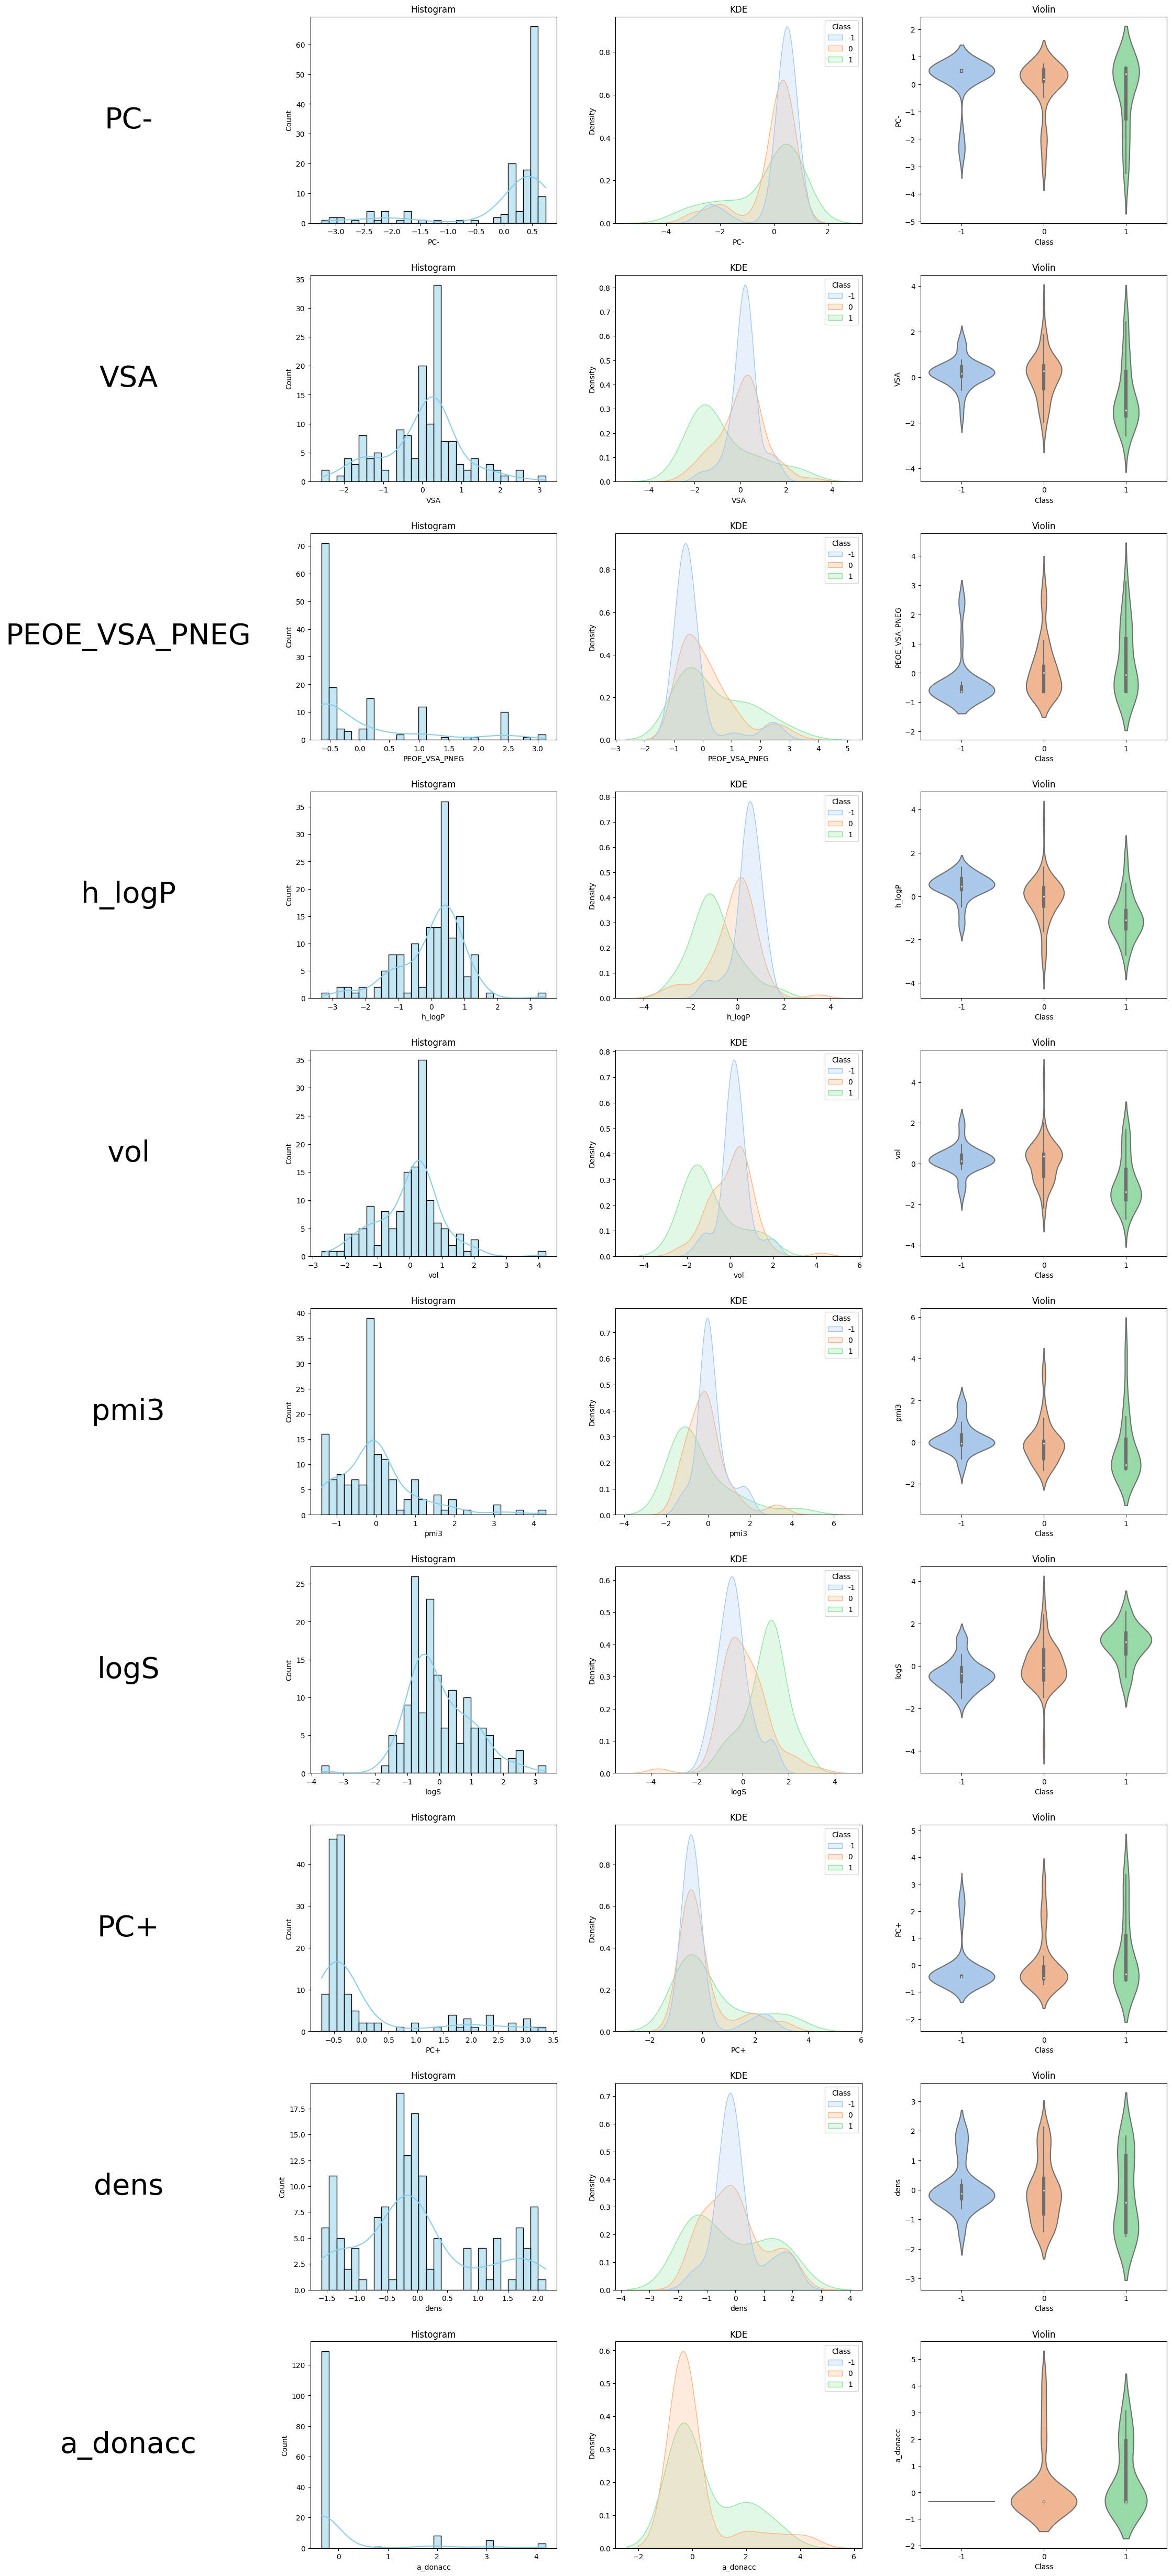

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(data, features_to_plot):
    """
    For each column given in features_to_plot, plot a histogram of the values in the column, smoothed histograms of the distribution according to the 'Class' column and a violin of the values according to the 'Class' column.
    :param data: pandas DataFrame
    :param features_to_plot: list of strings
    """
    _, axs = plt.subplots(len(features_to_plot), 4, figsize=(24, 5 * len(features_to_plot)))
    plt.tight_layout(pad=5.0)
    for i, feature in enumerate(features_to_plot):
        axs[i, 0].text(0.5, 0.5, feature, ha='center', va='center', fontsize=40)
        axs[i, 0].axis('off')
        axs[i, 1].set_title('Histogram')
        axs[i, 2].set_title('KDE')
        axs[i, 3].set_title('Violin')
        sns.histplot(data[feature], ax=axs[i, 1], bins=30, kde=True, color='skyblue')
        sns.kdeplot(data, x=feature, hue='Class', ax=axs[i, 2], fill=True, common_norm=False, warn_singular=False, palette='pastel')
        sns.violinplot(data=data, x='Class', y=feature, ax=axs[i, 3], palette='pastel')

plot_distribution(data, selected_features_XGB)

### 1.(b) Corrélation entre les attributs

#### Visualisation des corrélation entre les attributs sélectionnés

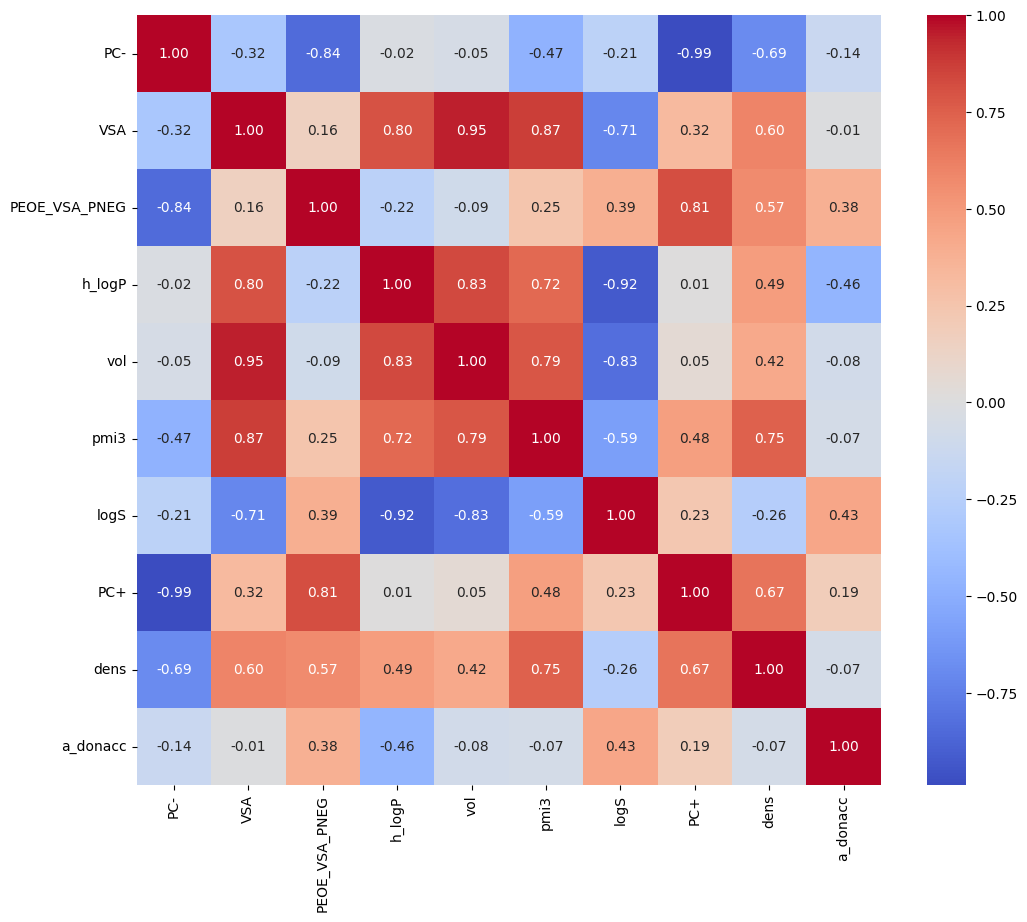

In [126]:
def plot_correlation(data, features_to_plot=None):
    """
    Plot a heatmap of the correlation matrix of the dataset.
    :param data: pandas DataFrame
    :param features_to_plot: list of strings, if given, plot a heatmap of the correlation matrix of the given features only
    """
    if features_to_plot:
        data = data[features_to_plot]
    plt.figure(figsize=(12, 10))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')

plot_correlation(data, selected_features_XGB)

Plus une couleur est intense (que ce soit dans le bleu ou dans le rouge), plus la corrélation est forte.

On constate ainsi que certaines corrélations sont très élévées, par exemple entre 'PC' et 'PC+' (-0.99) ou entre 'vol' et 'VSA' (0.95). Assez peu de couples présentent une corrélation faible.

Cela signifie que ces attributs sont redondants et qu'il est possbible de réduire la dimension de l'espace dans lequel sont exprimées les données sans perdre d'information.

#### Visualisation des corrélation entre les attributs au sein de chaque classe

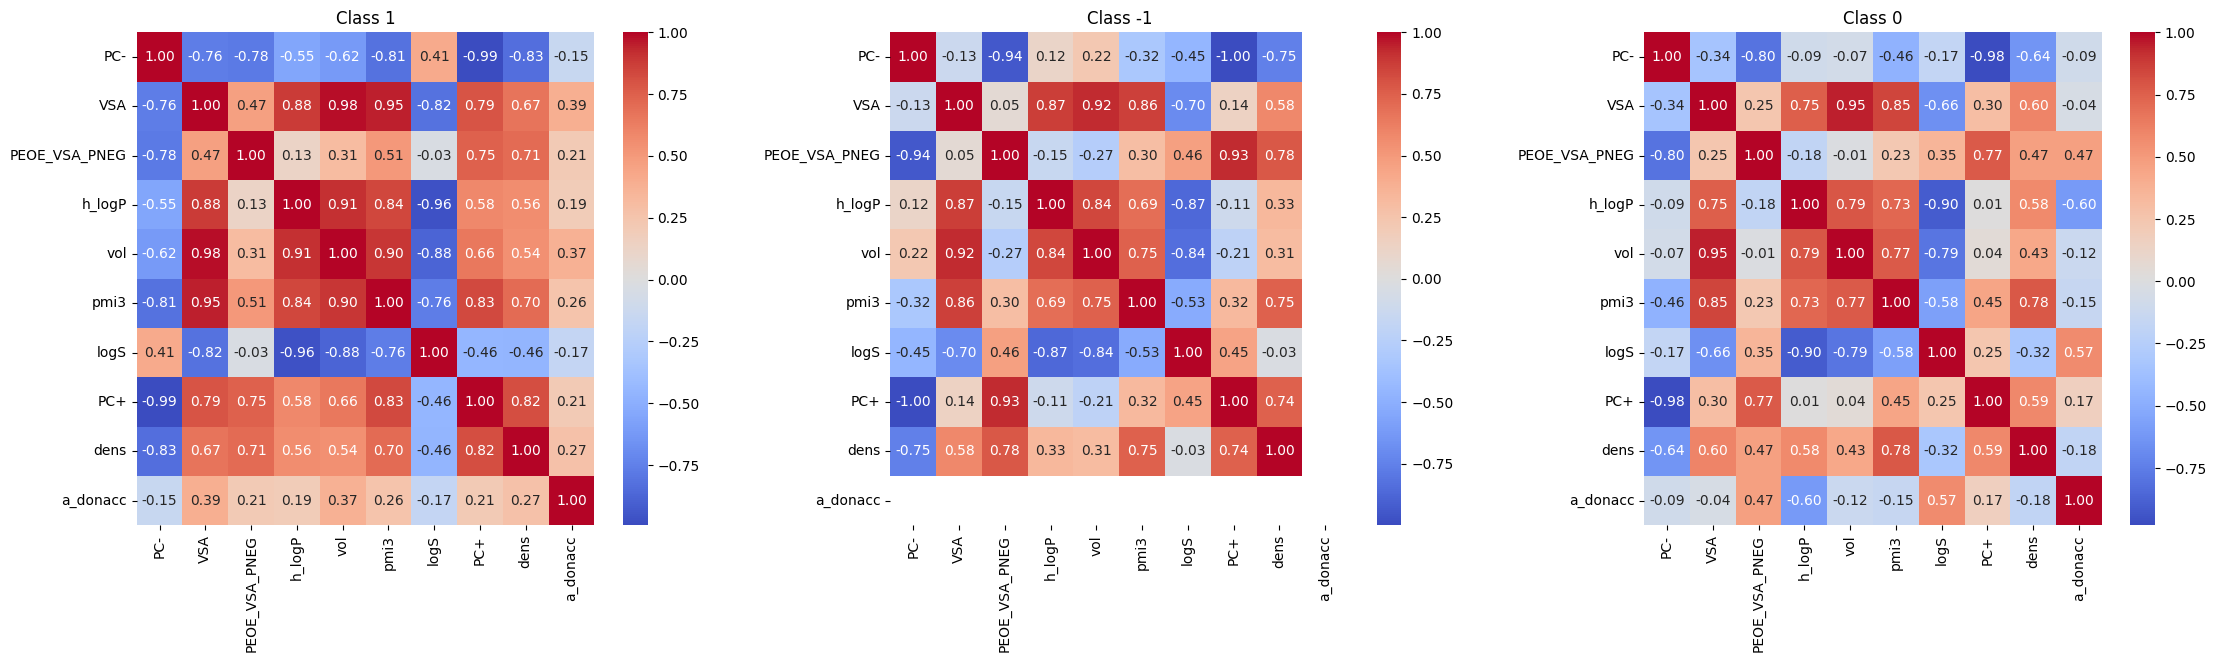

In [124]:
def plot_correlation_by_class(data, features_to_plot=None):
    """
    For each class in the 'Class' column, plot a heatmap of the correlation matrix of the given features.
    :param data: pandas DataFrame
    :param features_to_plot: list of strings
    """
    if features_to_plot:
        data = data[features_to_plot + ['Class']]
    _, axs = plt.subplots(1, 3, figsize=(24, 8))
    plt.tight_layout(pad=10.0)
    for i, class_ in enumerate(data['Class'].unique()):
        data_class = data[data['Class'] == class_]
        data_class = data_class.drop(columns=['Class'])
        axs[i].set_title(f'Class {class_}')
        sns.heatmap(data_class.corr(), annot=True, cmap='coolwarm', fmt='.2f', ax=axs[i])

plot_correlation_by_class(data, selected_features_XGB)